In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
from tqdm import tqdm
from igraph import Graph
import json

import sys
sys.path.append("../")
#from utils.reinforcement_learning.dqn_HD import DQN
from utils.reinforcement_learning.dqn import DQN
#from utils.params import Params
from utils.hyperparameters.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel
from utils.validation import get_Validation, area_under_curve
from utils.environment.game import GraphGame
from utils.environment.nodeCentrality import Node_Centrality
from utils.environment.globalFeature import Global_Feature
from utils.environment.envhelper import reset
from utils.reinforcement_learning.rl_environment import Environment

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def input_graph(graph_path,file):
    GRAPH = Graph.Read_Ncol(graph_path+str(file)+".txt", directed=False)
    nodes = [v.index for v in GRAPH.vs]
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(GRAPH)  
    Graph.simplify(GRAPH)
    return GRAPH, map

def CV_evaluation(graph_path,filename, parameter_path):  
    params = Params(parameter_path)
    file_list = []
    AUC = []
    x_label = []
    start = int(params.save_every)
    end = int(params.num_train_episodes)+start
    interval = int(params.save_every)
    nodeCentrality = Node_Centrality(params.centrality_feature_name)
    globalFeature = Global_Feature(params.global_feature_name)
    for iteration in np.arange(start,end,interval):
        name = "../"+ params.checkpoint_dir+"_"+str(iteration)
        model = torch.load(name)
        auc_individual = []
        for file in filename:
            GRAPH, _ = input_graph(graph_path,file)
            N = GRAPH.vcount()
            game = GraphGame
            env = Environment(game)
            attacker = DQN(state_representation_size=params.centrality_features,
                            hidden_layers_sizes= params.hidden_layers,
                           global_feature_size =params.global_features)
            attacker._q_network.load_state_dict(model["_q_network"])
            attacker._optimizer.load_state_dict(model["_optimizer"])
            rewards, lcc, actions = EvaluateModel(env,nodeCentrality,globalFeature, attacker,GRAPH)
            #Compute Area under the curve
            x =  np.flip(np.arange(N)[N:0:-1]/N)
            auc_individual.append(area_under_curve(x[:len(lcc)],lcc))
        AUC.append(np.mean(auc_individual))
        x_label.append(iteration)
    AUC = np.array(AUC)
    x_label = np.array(x_label)
    return x_label, AUC
def get_cv(parameter,feature,result,save_file):
    value = {}
    graph_path ="../Dataset/SyntheticGraph/"
    filename = ['barabasi_albert_' + str(i) for i in [30,50]]
    x, ba = CV_evaluation(graph_path,filename,parameter)
    value['ba'] = ba
    filename = ['erdos_renyi_' + str(i) for i in  [30,50]]
    x,er = CV_evaluation(graph_path,filename,parameter)
    value['er'] = er
    filename = ['small-world_' + str(i) for i in  [30,50]]
    x,sw = CV_evaluation(graph_path,filename,parameter)
    value['x'] = x
    value['sw'] = sw
    result[feature] = value
    with open(save_file, "w") as outfile:
        json.dump(result, outfile, cls=NpEncoder)


In [11]:
global_feature = ["None","Density","Heterogeneity","Resilience","Entropy","Transitivity","All"]

# Thompson Sampling: Compare Feature

In [4]:
for feature in global_feature:
    parameter_file =[("../utils/hyperparameters/BA/ba_params_"+feature+".json",'evaluation_ba.json'),("../utils/hyperparameters/Mix/mixed_params_"+feature+".json",'evaluation_mix.json')]
    for parameter,save_file in parameter_file:
        with open(save_file) as json_file:
            result = json.load(json_file)
        get_cv(parameter,feature,result,save_file)

/home/bhandk/AttackandDefend/Evaluation_Notebook/../utils/environment/nodeCentrality.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x = np.column_stack(centrality.values())


# Thompson Sampling: CN

In [5]:
global_feature = ["CN"]
for feature in global_feature:
    parameter_file =[("../utils/hyperparameters/BA/ba_params_CN.json",'evaluation_ba.json'),("../utils/hyperparameters/Mix/mixed_params_CN.json",'evaluation_mix.json')]
    for parameter,save_file in parameter_file:
        with open(save_file) as json_file:
            result = json.load(json_file)
        get_cv(parameter,feature,result,save_file)

In [9]:
def get_value(result,evaluation,typeGraph=None,result_filter=None):
    plt.figure(figsize=(10, 8), dpi=80)
    result_feature = list(result.keys())
    if result_filter != None:
        result_feature = set(result_feature).intersection(result_filter)
    for feature in result_feature:
        x = result[feature]["x"]
        if feature == global_feature[0]:
           color = 'red'
           inv = 'red'
        elif feature == global_feature[1]:
            color = 'blue'
            inv = 'blue'
        elif feature == global_feature[2]:
            color = 'orange'
            inv = 'orange'
        elif feature == global_feature[3]:
            color = 'purple'
            inv = 'purple'
        elif feature == global_feature[4]:
            color = 'yellow'
            inv = 'yellow'
        elif feature == global_feature[5]:
            color = 'pink'
            inv = 'pink'
        else:
            color = 'green'
            inv = 'green'
        label = feature
        if evaluation == "all":
            auc = np.mean([result[feature]['ba'],result[feature]['er'],result[feature]['sw']],axis=0)
        else:        
            auc = result[feature][evaluation]
        min_value = np.argmin(auc)
        min_vc = x[min_value]
        plt.plot(x,auc, color = color)
        plt.plot(min_vc, auc[min_value], marker="o", color = color,markersize=5, markeredgecolor=color, markerfacecolor="None",label= label+": "+str(min_vc))
    plt.title("AUC of LCC vs Nodes Plot "+""+evaluation.upper()+" type graph")
    plt.legend()
    if typeGraph == None:
        plt.savefig("./Figure/Eval_"+evaluation+".pdf")
    else:
        plt.savefig("./Figure/Eval_"+typeGraph+"_"+evaluation+".pdf")
    plt.show()

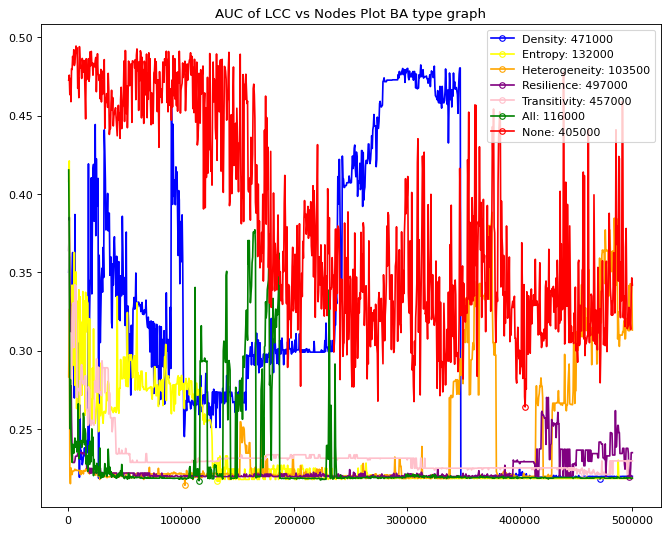

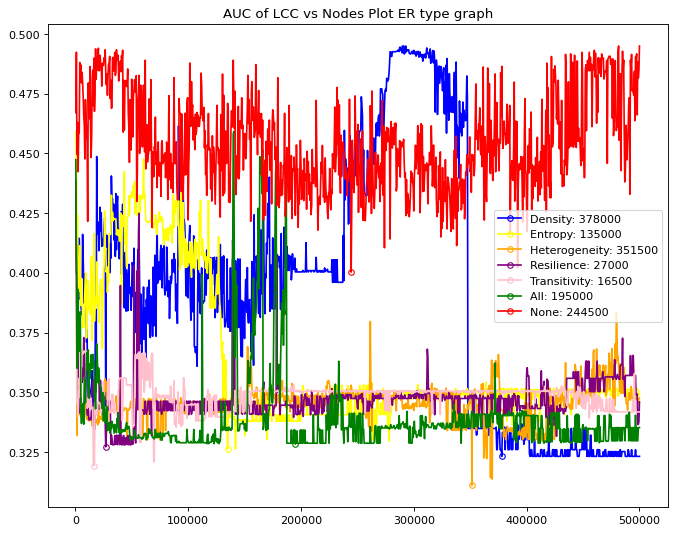

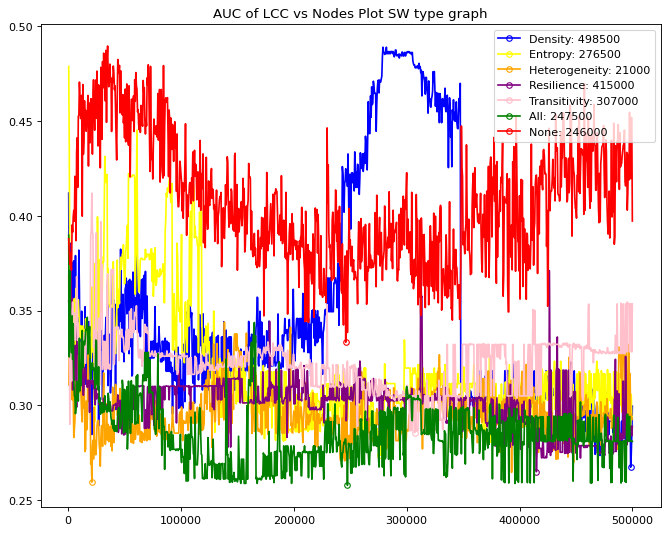

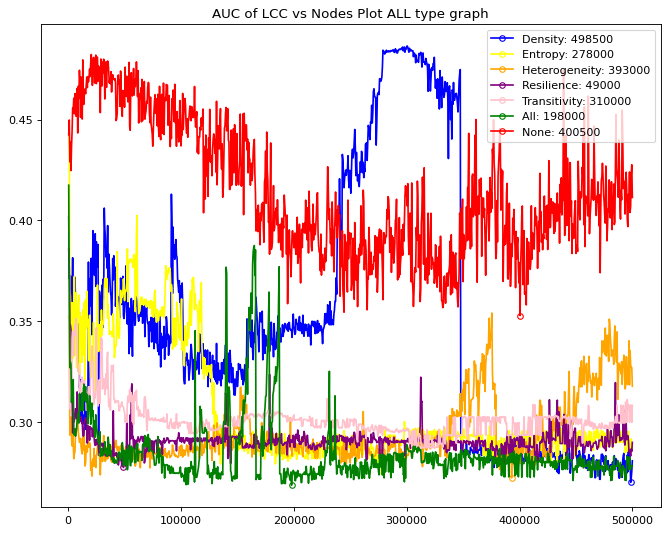

In [12]:
with open('evaluation_ba.json') as json_file:
    result = json.load(json_file)
get_value(result,"ba","BA",global_feature)
get_value(result,"er","BA",global_feature)
get_value(result,"sw","BA",global_feature)
get_value(result,"all","BA",global_feature)

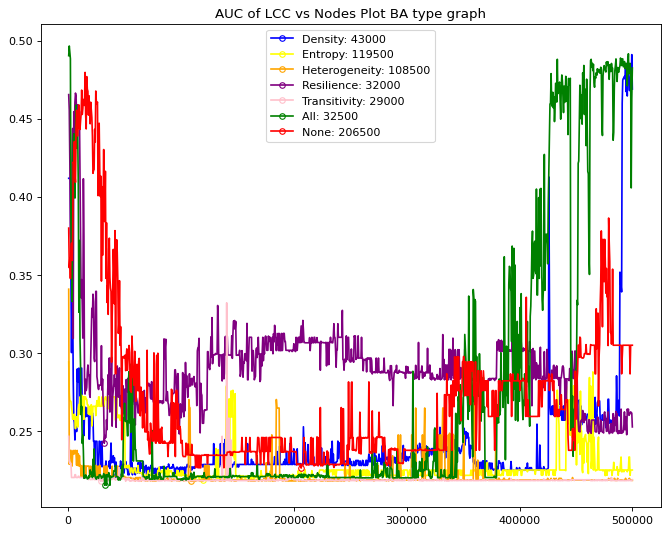

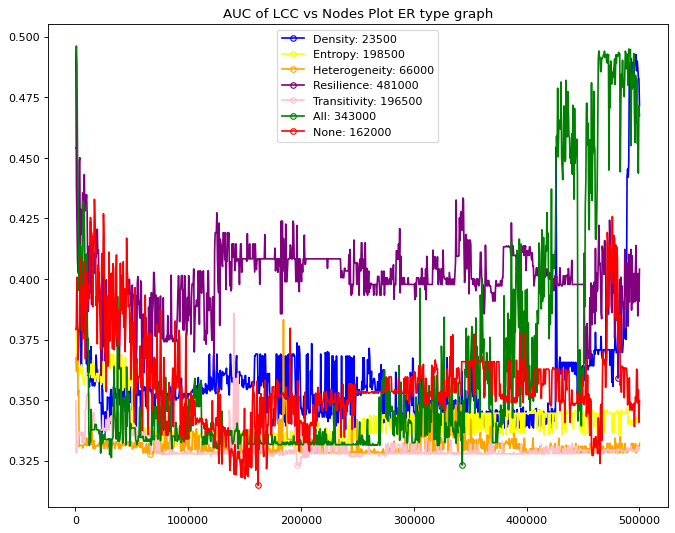

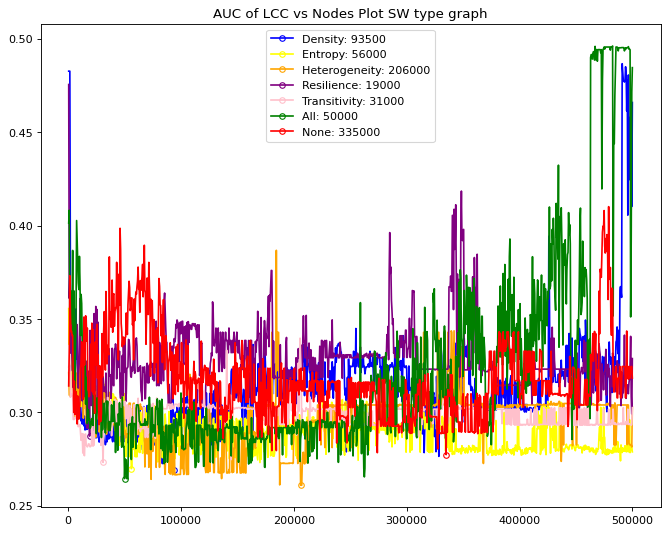

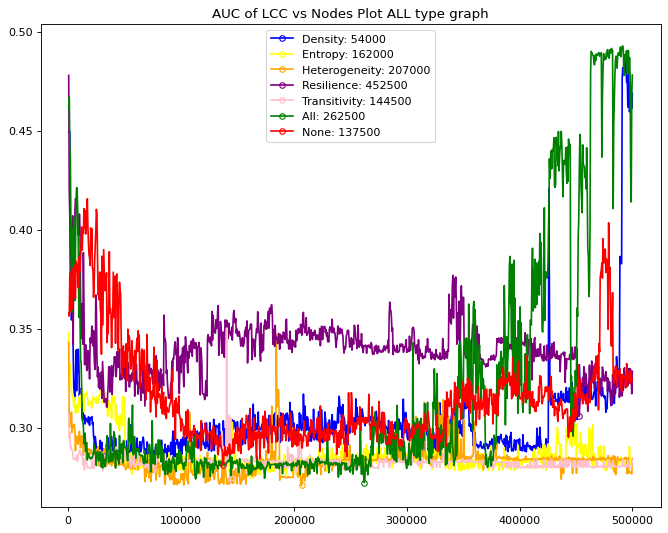

In [13]:
with open('evaluation_mix.json') as json_file:
    result = json.load(json_file)
get_value(result,"ba","mix",global_feature)
get_value(result,"er","mix",global_feature)
get_value(result,"sw","mix",global_feature)
get_value(result,"all","mix",global_feature)

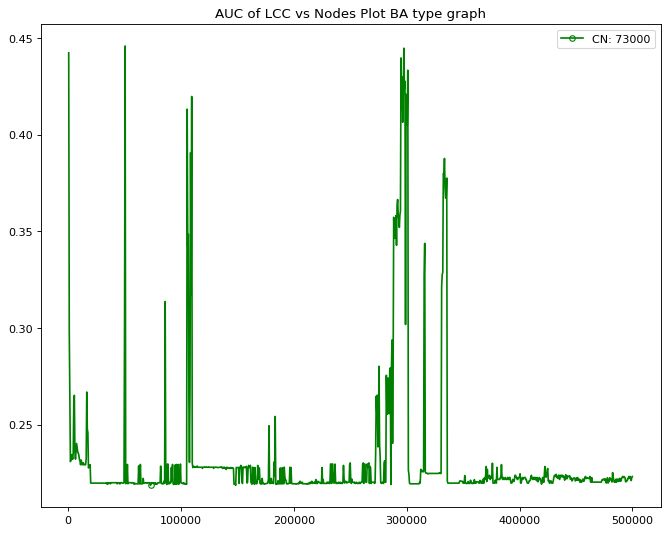

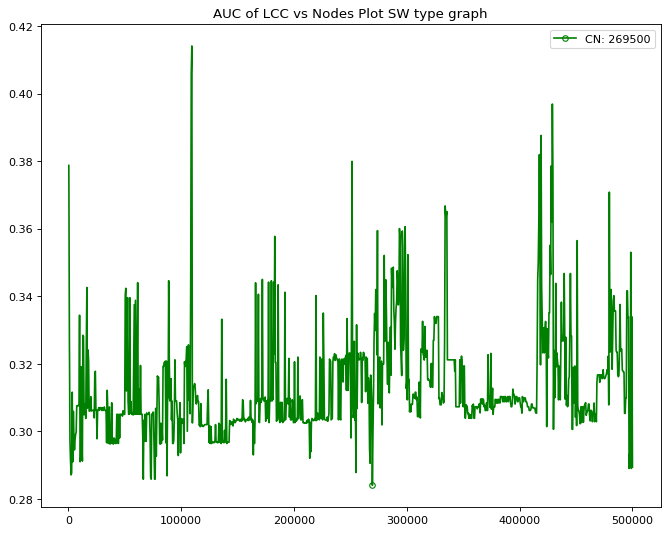

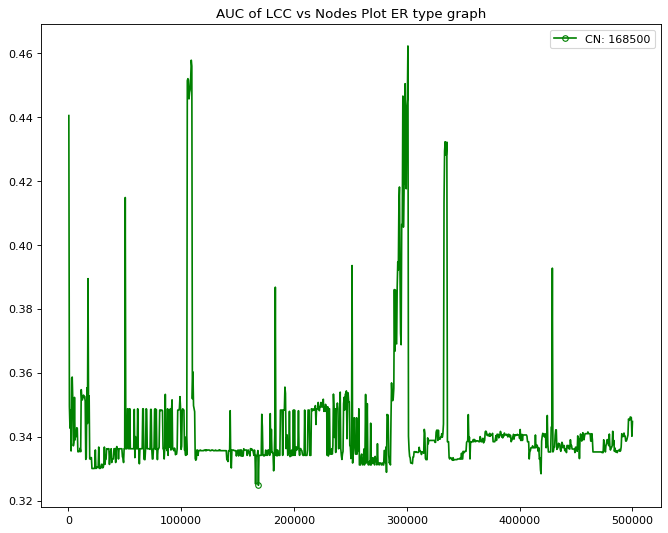

In [18]:
with open('evaluation_ba.json') as json_file:
    result = json.load(json_file)
get_value(result,"ba","BA",["CN"])
get_value(result,"sw","BA",["CN"])
get_value(result,"er","BA",["CN"])

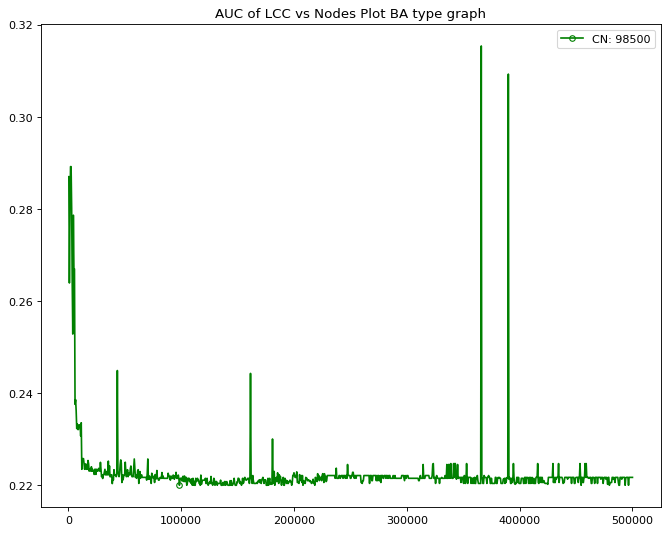

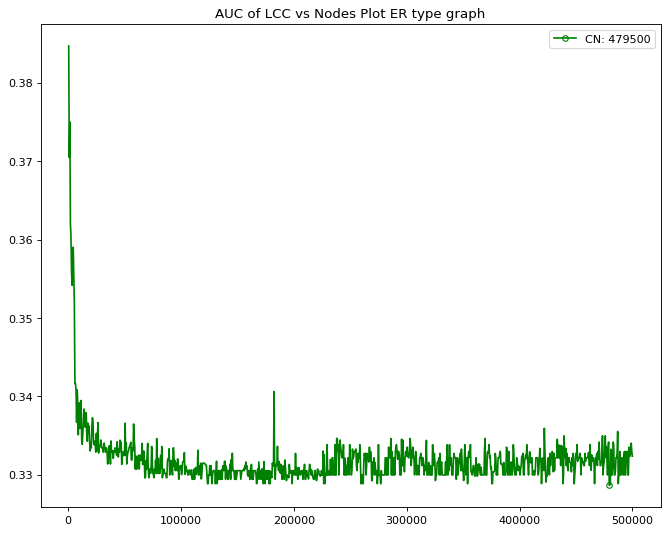

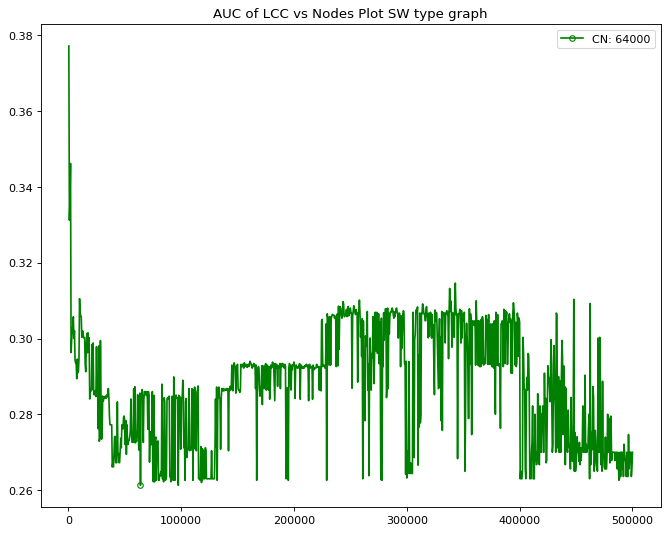

In [19]:
with open('evaluation_mix.json') as json_file:
    result = json.load(json_file)
get_value(result,"ba","mix",["CN"])
get_value(result,"er","mix",["CN"])
get_value(result,"sw","mix",["CN"])